In [0]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision torchtext
import torch

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!python -m spacy download en

Mounted at /content/gdrive

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')



In [0]:
# DATA

import pandas as pd
import numpy as np
import os
from torchtext import data, vocab
import torch
from random import randint

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


class MovieLens:
    """
    Class to handle the MovieLens data
    """

    def __init__(self, device, path='./gdrive/My Drive/Colab Notebooks/data/MovieLens-Small/ratings.csv'):
        print('Device: ' + str(device))

        self.user = data.Field(sequential=False, use_vocab=True)
        self.movie = data.Field(sequential=False, use_vocab=True)
        self.rating = data.Field(sequential=False, use_vocab=False, dtype=torch.float)

        self.train_set, self.validation_set, self.test_set = data.TabularDataset(
            path=path,
            format='csv',
            fields=[('user', self.user), ('movie', self.movie), ('rating', self.rating), ('timestamp', None)],
            skip_header=True,
        ).split(split_ratio=[0.7, 0.15, 0.15])

        self.train_iter, self.validation_iter, self.test_iter = data.BucketIterator.splits(
            (self.train_set, self.validation_set, self.test_set),
            batch_size=100,
            device=device,
            sort_key=lambda x: len(x.movie),
            repeat=False)

        self.user.build_vocab(self.train_set)
        self.movie.build_vocab(self.train_set)

In [0]:
#MODEL

import torch.nn as nn
import numpy as np

max_rating = 5.0
min_rating = 0.5

class MovieLensNet(nn.Module):
    def __init__(self, user_field, movie_field, n_factors=10, hidden=50, p1=0, p2=0):
        super().__init__()
        self.movie_field = movie_field
        self.user_field = user_field

        n_users = len(self.user_field.vocab.itos)
        self.u = nn.Embedding(n_users, n_factors)
        self.u.weight.data.uniform_(0,  0.05)
        self.u.requires_grad = False

        n_movies = len(self.movie_field.vocab.itos)
        self.m = nn.Embedding(n_movies, n_factors)
        self.m.weight.data.uniform_(0,  0.05)
        self.m.requires_grad = False

        self.lin1 = nn.Sequential(
            nn.Dropout(p1),
            nn.Linear(n_factors * 2, hidden),
            # nn.ReLU(),
        )

        self.lin2 = nn.Sequential(
            nn.Dropout(p2),
            nn.Linear(hidden, 1),
        )

    def forward(self, batch):
        x = torch.cat([self.u(batch.user), self.m(batch.movie)], dim=1)
        x = self.lin1(x)
        x = self.lin2(x)
        return (torch.sigmoid(x) * (max_rating - min_rating)) + min_rating


In [0]:
#Training
from types import SimpleNamespace
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from random import randint

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


def movie_lens_train(train_iter, val_iter, net, test_iter, optimizer, criterion, num_epochs=5):
    train_err = []
    train_res = []
    val_err = []
    val_res = []

    for i in range(num_epochs):
        net.train()
        train_loss, train_accs, train_avg_dist, train_length = [0, 0, 0, 0]
        
        for batch in train_iter:
            output = net(batch).reshape(-1)
            batch_loss = criterion(output, batch.rating)
            
            train_loss += batch_loss
            train_length += batch.batch_size
            train_accs += accuracy(output, batch.rating) * batch.batch_size
            train_avg_dist += avg_distance(output, batch.rating) * batch.batch_size

            #optimization step
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

        # print results after each epoch
        train_loss /= train_length
        train_loss /= (max_rating-min_rating) # get percentage of error
        train_accs /= train_length
        train_avg_dist /= train_length

        net.eval()
        val_loss, val_accs, val_avg_dist, val_length = [0, 0, 0, 0]

        for val_batch in val_iter:
            val_output = net(val_batch).reshape(-1)
            val_loss += criterion(val_output, val_batch.rating)
            val_length += val_batch.batch_size
            val_accs += accuracy(val_output, val_batch.rating) * val_batch.batch_size
            val_avg_dist += avg_distance(val_output, val_batch.rating) * val_batch.batch_size

        # print results after each epoch
        val_loss /= val_length
        val_loss /= (max_rating-min_rating) # get percentage of error
        val_accs /= val_length
        val_avg_dist /= val_length
            
        train_res.append(train_accs)
        train_err.append(train_avg_dist/(max_rating-min_rating))
        val_res.append(val_accs)
        val_err.append(val_avg_dist/(max_rating-min_rating))
            
        print("Epoch {}: Train loss: {:.4f},  Train accs: {:.4f}, Train average distance: {:.2f}".format(i + 1, train_loss, train_accs, train_avg_dist))
        print("         Validation loss: {:.4f},  Validation accs:{:.4f}, Validation average distance: {:.2f} ".format(val_loss, val_accs, val_avg_dist))
        val_loss, val_accs, val_length = [0, 0, 0]
        
    return (train_res, train_err, val_res, val_err)


def accuracy(output, target):
    return np.sum(torch.mean(torch.lt(torch.abs(output-target), 0.5).float()).cpu().data.numpy())
  
def avg_distance(output, target):
    return np.sum(torch.mean(torch.abs(output-target)).float().cpu().data.numpy())

In [0]:
#MAIN

import torch
from torch import optim, nn

movie_data = MovieLens(device=device)

train_set = movie_data.train_iter
test_set = movie_data.test_iter
validation_set = movie_data.validation_iter

user_field = movie_data.user
movie_field = movie_data.movie

print('Data loaded')

Device: cuda:0
Data loaded


In [0]:
net = MovieLensNet(user_field=user_field, movie_field=movie_field, n_factors=10, hidden=20, p1=0, p2=0).to(device)

opt = optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-6)
#opt = optim.SGD(net.parameters(), lr= 1e-1, weight_decay=1e-5, momentum=0.9)

criterion = nn.MSELoss()
train_res, train_err, val_res, val_err = movie_lens_train(train_iter=train_set, test_iter=test_set, val_iter=validation_set,
      net=net, optimizer=opt, criterion=criterion, num_epochs=30)

Epoch 1: Train loss: 0.0028,  Train accs: 0.3064, Train average distance: 0.92
         Validation loss: 0.0025,  Validation accs:0.3236, Validation average distance: 0.86 
Epoch 2: Train loss: 0.0023,  Train accs: 0.3870, Train average distance: 0.81
         Validation loss: 0.0022,  Validation accs:0.4211, Validation average distance: 0.79 
Epoch 3: Train loss: 0.0020,  Train accs: 0.4389, Train average distance: 0.75
         Validation loss: 0.0020,  Validation accs:0.4319, Validation average distance: 0.74 
Epoch 4: Train loss: 0.0019,  Train accs: 0.4505, Train average distance: 0.71
         Validation loss: 0.0019,  Validation accs:0.4408, Validation average distance: 0.72 
Epoch 5: Train loss: 0.0018,  Train accs: 0.4614, Train average distance: 0.69
         Validation loss: 0.0018,  Validation accs:0.4457, Validation average distance: 0.70 
Epoch 6: Train loss: 0.0017,  Train accs: 0.4705, Train average distance: 0.67
         Validation loss: 0.0018,  Validation accs:0.451

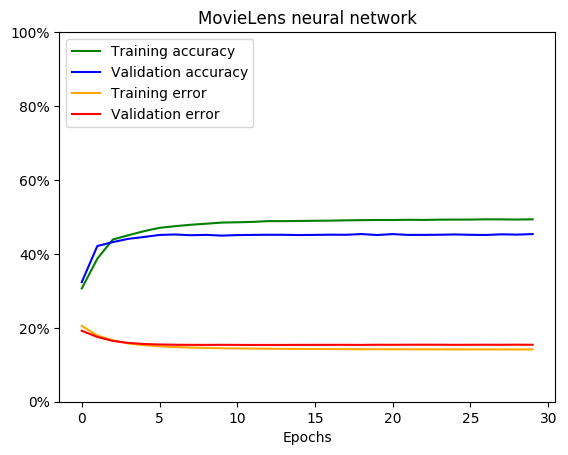

In [0]:
# Visualization

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.style.use('default')


def getPerc(array):
  return [item*100.0 for item in array]

simple = []

epochs = range(len(train_res))

plt.plot(epochs, getPerc(train_res), 'green', label='Training accuracy')
plt.plot(epochs, getPerc(val_res), 'blue', label='Validation accuracy')


plt.plot(epochs, getPerc(train_err), 'orange', label='Training error')
plt.plot(epochs, getPerc(val_err), 'red', label='Validation error')


plt.legend(loc='upper left')
plt.title("MovieLens neural network")
plt.xlabel('Epochs')
plt.ylim(0,100)

#plt.yaxis.set_major_formatter(FuncFormatter(lambda x, p: '{}%'.format(x)))

plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
plt.show()
#plt.savefig('destination_path.eps', format='eps', dpi=1000)